This is a companion notebook for the book [Deep Learning with Python, Second Edition](https://www.manning.com/books/deep-learning-with-python-second-edition?a_aid=keras&a_bid=76564dff). For readability, it only contains runnable code blocks and section titles, and omits everything else in the book: text paragraphs, figures, and pseudocode.

**If you want to be able to follow what's going on, I recommend reading the notebook side by side with your copy of the book.**

This notebook was generated for TensorFlow 2.6.

# Deep learning for timeseries

## Different kinds of timeseries tasks

## A temperature-forecasting example

In [2]:
!wget https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
!unzip jena_climate_2009_2016.csv.zip

--2023-07-05 14:02:17--  https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.162.69, 52.216.207.77, 52.217.197.240, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.162.69|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13565642 (13M) [application/zip]
Saving to: ‘jena_climate_2009_2016.csv.zip’

jena_climate_2009_2 100%[===================>]  12.94M  19.0MB/s    in 0.7s    

2023-07-05 14:02:18 (19.0 MB/s) - ‘jena_climate_2009_2016.csv.zip’ saved [13565642/13565642]

Archive:  jena_climate_2009_2016.csv.zip
  inflating: jena_climate_2009_2016.csv  
  inflating: __MACOSX/._jena_climate_2009_2016.csv  


**Inspecting the data of the Jena weather dataset**

In [3]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()

lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


**Parsing the data**

In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

**Plotting the temperature timeseries**

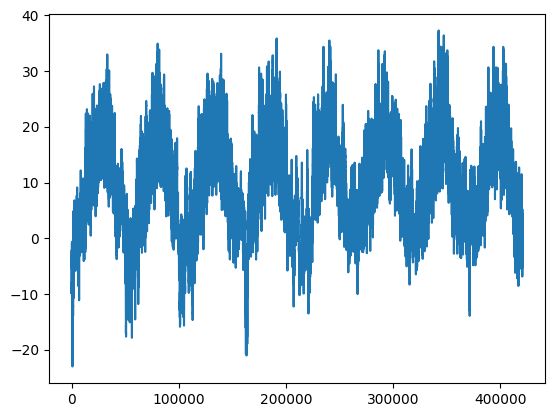

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)

**Plotting the first 10 days of the temperature timeseries**

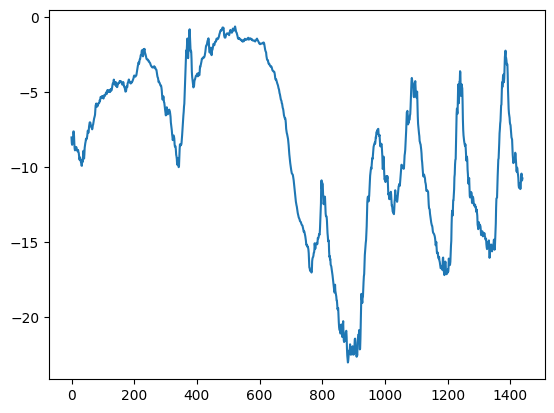

In [6]:
plt.plot(range(1440), temperature[:1440])

**Computing the number of samples we'll use for each data split**

In [5]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


### Preparing the data

**Normalizing the data**

In [6]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [7]:
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,
)

for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))

[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


**Instantiating datasets for training, validation, and testing**mm

In [8]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

**Inspecting the output of one of our datasets**

In [12]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


### A common-sense, non-machine-learning baseline

**Computing the common-sense baseline MAE**

In [9]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


### Let's try a basic machine-learning model

**Training and evaluating a densely connected model**

In [32]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 53s 63ms/step - loss: 12.5578 - mae: 2.7582 - val_loss: 10.2335 - val_mae: 2.5171
Epoch 2/10
819/819 [==============================] - 38s 46ms/step - loss: 9.1807 - mae: 2.3857 - val_loss: 10.1972 - val_mae: 2.5162
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.2992 - mae: 2.2684 - val_loss: 10.7553 - val_mae: 2.5816
Epoch 4/10
819/819 [==============================] - 47s 57ms/step - loss: 7.7615 - mae: 2.1938 - val_loss: 10.7683 - val_mae: 2.5812
Epoch 5/10
819/819 [==============================] - 47s 57ms/step - loss: 7.4680 - mae: 2.1518 - val_loss: 10.9183 - val_mae: 2.5990
Epoch 6/10
819/819 [==============================] - 39s 48ms/step - loss: 7.1631 - mae: 2.1083 - val_loss: 13.0495 - val_mae: 2.8559
Epoch 7/10
819/819 [==============================] - 43s 52ms/step - loss: 6.9575 - mae: 2.0785 - val_loss: 10.4979 - val_mae: 2.5406
Epoch 8/10
819/819 [==============================] - 

**Plotting results**

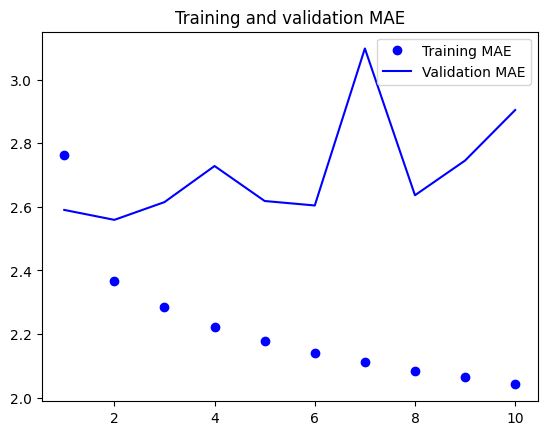

In [15]:
import matplotlib.pyplot as plt

def plt_show(history):
  loss = history.history["mae"]
  val_loss = history.history["val_mae"]
  epochs = range(1, len(loss) + 1)
  plt.figure()
  plt.plot(epochs, loss, "bo", label="Training MAE")
  plt.plot(epochs, val_loss, "b", label="Validation MAE")
  plt.title("Training and validation MAE")
  plt.legend()
  plt.show()
plt_show(history)

### Let's try a 1D convolutional model

In [33]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_conv.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 50s 52ms/step - loss: 24.5118 - mae: 3.8493 - val_loss: 20.2170 - val_mae: 3.5299
Epoch 2/10
819/819 [==============================] - 42s 51ms/step - loss: 15.6765 - mae: 3.1374 - val_loss: 16.4874 - val_mae: 3.1862
Epoch 3/10
819/819 [==============================] - 50s 60ms/step - loss: 14.4296 - mae: 3.0108 - val_loss: 15.7456 - val_mae: 3.1082
Epoch 4/10
819/819 [==============================] - 54s 66ms/step - loss: 13.7698 - mae: 2.9395 - val_loss: 20.1417 - val_mae: 3.5148
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 13.2427 - mae: 2.8819 - val_loss: 15.1334 - val_mae: 3.0616
Epoch 6/10
819/819 [==============================] - 51s 62ms/step - loss: 12.8094 - mae: 2.8333 - val_loss: 14.5482 - val_mae: 3.0059
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 12.4285 - mae: 2.7900 - val_loss: 16.3012 - val_mae: 3.1755
Epoch 8/10
819/819 [============================

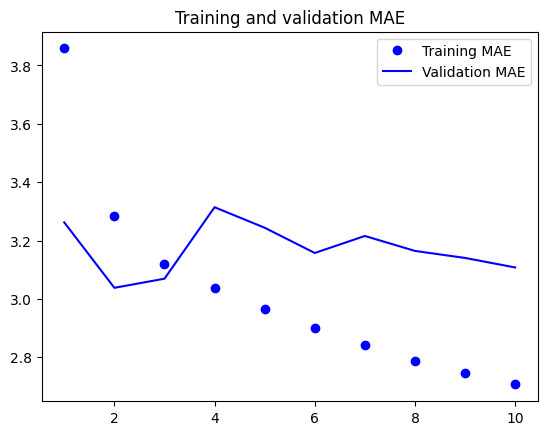

In [19]:
plt_show(history)

### A first recurrent baseline

**A simple LSTM-based model**

In [16]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 59s 62ms/step - loss: 35.9566 - mae: 4.3611 - val_loss: 11.6033 - val_mae: 2.6030
Epoch 2/10
819/819 [==============================] - 43s 52ms/step - loss: 10.7759 - mae: 2.5601 - val_loss: 9.5427 - val_mae: 2.4092
Epoch 3/10
819/819 [==============================] - 43s 52ms/step - loss: 9.9160 - mae: 2.4563 - val_loss: 9.3047 - val_mae: 2.3765
Epoch 4/10
819/819 [==============================] - 50s 61ms/step - loss: 9.4806 - mae: 2.3984 - val_loss: 9.2858 - val_mae: 2.3668
Epoch 5/10
819/819 [==============================] - 42s 52ms/step - loss: 9.1399 - mae: 2.3529 - val_loss: 9.4936 - val_mae: 2.3955
Epoch 6/10
819/819 [==============================] - 42s 51ms/step - loss: 8.9367 - mae: 2.3247 - val_loss: 9.3125 - val_mae: 2.3831
Epoch 7/10
819/819 [==============================] - 42s 51ms/step - loss: 8.7396 - mae: 2.2998 - val_loss: 9.5199 - val_mae: 2.4040
Epoch 8/10
819/819 [==============================] - 43s 5

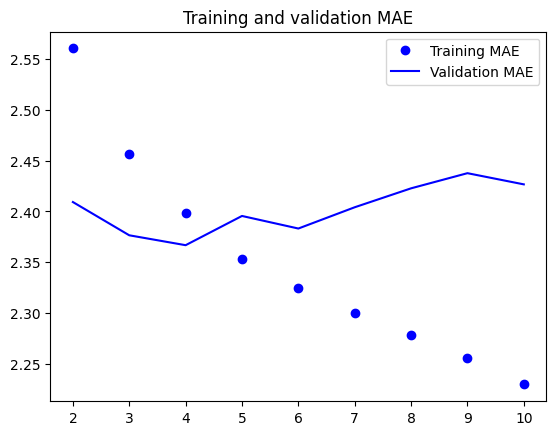

In [25]:
loss = history.history["mae"][1:]
val_loss = history.history["val_mae"][1:]
epochs = range(2, len(loss) + 2)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

## Understanding recurrent neural networks

**NumPy implementation of a simple RNN**mm

In [27]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)

### A recurrent layer in Keras

**An RNN layer that can process sequences of any length**

In [28]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

**An RNN layer that returns only its last output step**

In [29]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


**An RNN layer that returns its full output sequence**

In [15]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)

(None, 120, 16)


**Stacking RNN layers**

In [31]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

## Advanced use of recurrent neural networks

### Using recurrent dropout to fight overfitting

**Training and evaluating a dropout-regularized LSTM**

In [12]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)

Epoch 1/50
819/819 [==============================] - 224s 269ms/step - loss: 26.7170 - mae: 3.8283 - val_loss: 9.9488 - val_mae: 2.4439
Epoch 2/50
819/819 [==============================] - 232s 283ms/step - loss: 14.8769 - mae: 2.9956 - val_loss: 9.4665 - val_mae: 2.3824
Epoch 3/50
819/819 [==============================] - 232s 283ms/step - loss: 14.0373 - mae: 2.9036 - val_loss: 9.4071 - val_mae: 2.3806
Epoch 4/50
819/819 [==============================] - 240s 292ms/step - loss: 13.3686 - mae: 2.8377 - val_loss: 9.4955 - val_mae: 2.3865
Epoch 5/50
819/819 [==============================] - 233s 285ms/step - loss: 12.8001 - mae: 2.7752 - val_loss: 9.5398 - val_mae: 2.4068
Epoch 6/50
819/819 [==============================] - 235s 287ms/step - loss: 12.4878 - mae: 2.7412 - val_loss: 9.5492 - val_mae: 2.4096
Epoch 7/50
819/819 [==============================] - 241s 294ms/step - loss: 12.1774 - mae: 2.7094 - val_loss: 9.3023 - val_mae: 2.3679
Epoch 8/50
819/819 [=====================

In [16]:
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

### Stacking recurrent layers

**Training and evaluating a dropout-regularized, stacked GRU model**

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

### Using bidirectional RNNs

**Training and evaluating a bidirectional LSTM**

In [13]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)

Epoch 1/10
819/819 [==============================] - 176s 209ms/step - loss: 26.2864 - mae: 3.6716 - val_loss: 10.1962 - val_mae: 2.4692
Epoch 2/10
819/819 [==============================] - 172s 210ms/step - loss: 9.5629 - mae: 2.4058 - val_loss: 9.4305 - val_mae: 2.3844
Epoch 3/10
819/819 [==============================] - 163s 199ms/step - loss: 8.6196 - mae: 2.2764 - val_loss: 9.8102 - val_mae: 2.4189
Epoch 4/10
819/819 [==============================] - 165s 201ms/step - loss: 8.1004 - mae: 2.2100 - val_loss: 10.0859 - val_mae: 2.4426
Epoch 5/10
819/819 [==============================] - 165s 201ms/step - loss: 7.7708 - mae: 2.1637 - val_loss: 9.4988 - val_mae: 2.3874
Epoch 6/10
819/819 [==============================] - 177s 215ms/step - loss: 7.4510 - mae: 2.1174 - val_loss: 9.7573 - val_mae: 2.4244
Epoch 7/10
819/819 [==============================] - 277s 338ms/step - loss: 7.1961 - mae: 2.0820 - val_loss: 9.9881 - val_mae: 2.4424
Epoch 8/10
819/819 [=========================

### Going even further

## Summary

* As you first learned in chapter 5, when approaching a new problem, it’s good to
first establish common-sense baselines for your metric of choice. If you don’t
have a baseline to beat, you can’t tell whether you’re making real progress.
* Try simple models before expensive ones, to make sure the additional expense
is justified. Sometimes a simple model will turn out to be your best option.
* When you have data where ordering matters, and in particular for timeseries
data, recurrent networks are a great fit and easily outperform models that first flatten the temporal data. The two essential RNN layers available in Keras are the
LSTM layer and the GRU layer.
* To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all you have to do is use the recurrent_dropout arguments of recurrent
layers.
* Stacked RNNs provide more representational power than a single RNN layer.
They’re also much more expensive and thus not always worth it. Although they
offer clear gains on complex problems (such as machine translation), they may
not always be relevant to smaller, simpler problems.